In [ ]:
import csv
import math
import os
from dataclasses import dataclass, field
from typing import Optional


# ─── Configuration ───────────────────────────────────────────────────────────

# Configurable scoring weights (must sum to 1.0)
DEFAULT_WEIGHTS = {
    "extra_distance": 0.50,      # Minimize additional KM added to route
    "total_route_km": 0.20,      # Prefer routes that stay short overall
    "centroid_proximity": 0.15,  # Logically coherent geographic assignment
    "uti_headroom": 0.15,        # Prefer underutilized routes with capacity
}

# Road factor multiplier: Haversine gives straight-line distance.
# Multiply by this factor to approximate actual road distance.
ROAD_FACTOR = 1.3

# Milk spoilage constraint: max hours for total route duration (CC → HMBs → CC).
# Raw milk in non-refrigerated trucks spoils quickly — 4h hard limit.
MAX_ROUTE_HOURS = 4.0

# Average vehicle speed (km/h) for estimating route time
AVG_SPEED_KMH = 40.0

# Average time spent at each HMB for milk collection (hours)
AVG_STOP_TIME_HOURS = 10 / 60  # 10 minutes

# Uthangarai CC coordinates
CC_LAT = 12.308573
CC_LON = 78.535901

# Data directory (relative to this notebook — one level up, then into csv_files)
BASE_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
CSV_DIR = os.path.join(BASE_DIR, "csv_files")

In [ ]:
@dataclass
class HMB:
    """Represents a single milk collection point (Hire Milk Booth)."""
    sap_code: str
    name: str
    lat: float
    lon: float
    sequence: int
    distance_km: float  # Distance from previous stop (from master data)


@dataclass
class Route:
    """Represents a milk collection route with ordered HMB stops."""
    code: str              # e.g., "M10126"
    name: str              # e.g., "Bargoor"
    hmbs: list = field(default_factory=list)  # Ordered list of HMB objects
    total_km: float = 0.0
    capacity: int = 0
    current_milk_qty: float = 0.0
    uti_percent: float = 0.0
    transporter: str = ""
    vehicle_type: str = ""
    km_rate: float = 0.0
    fixed_rate: float = 0.0
    per_day_hire: float = 0.0
    cpl: float = 0.0

In [15]:
def haversine(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the great-circle distance between two GPS points.

    Args:
        lat1, lon1: Latitude and longitude of point 1 (degrees)
        lat2, lon2: Latitude and longitude of point 2 (degrees)

    Returns:
        Distance in kilometers (straight-line).
    """
    R = 6371.0  # Earth's radius in km

    lat1_r, lon1_r = math.radians(lat1), math.radians(lon1)
    lat2_r, lon2_r = math.radians(lat2), math.radians(lon2)

    dlat = lat2_r - lat1_r
    dlon = lon2_r - lon1_r

    a = math.sin(dlat / 2) ** 2 + \
        math.cos(lat1_r) * math.cos(lat2_r) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

def road_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Approximate road distance between two GPS points.
    Applies the road factor multiplier to Haversine distance.
    """
    return haversine(lat1, lon1, lat2, lon2) * ROAD_FACTOR


Data loading

In [16]:
def _parse_lat_lon(coord_str: str) -> Optional[tuple]:
    """Parse a 'lat, lon' string into (float, float). Returns None on failure."""
    if not coord_str or not coord_str.strip():
        return None
    try:
        parts = coord_str.strip().split(",")
        if len(parts) != 2:
            return None
        lat = float(parts[0].strip())
        lon = float(parts[1].strip())
        if -90 <= lat <= 90 and -180 <= lon <= 180:
            return (lat, lon)
        return None
    except (ValueError, IndexError):
        return None


def load_route_summary() -> dict:
    """
    Load route summary data from HMB Details_Summary.csv.

    Returns:
        Dict mapping route_code -> {capacity, milk_qty, total_km, ...}
    """
    summary_file = os.path.join(CSV_DIR, "HMB Details_Summary.csv")
    routes_info = {}

    with open(summary_file, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        header = next(reader)  # Skip header

        for row in reader:
            if not row or not row[0].strip() or row[0].strip() == "Grand Total":
                continue

            route_code = row[2].strip() if len(row) > 2 else ""
            if not route_code.startswith("M"):
                continue

            routes_info[route_code] = {
                "plant": row[0].strip(),
                "plant_name": row[1].strip(),
                "route_name": row[3].strip() if len(row) > 3 else "",
                "transporter_code": row[4].strip() if len(row) > 4 else "",
                "transporter_name": row[5].strip() if len(row) > 5 else "",
                "truck_no": row[6].strip() if len(row) > 6 else "",
                "vehicle_type": row[7].strip() if len(row) > 7 else "",
                "capacity": int(float(row[8])) if len(row) > 8 and row[8].strip() else 0,
                "milk_qty": float(row[9]) if len(row) > 9 and row[9].strip() else 0.0,
                "per_day_km": float(row[10]) if len(row) > 10 and row[10].strip() else 0.0,
                "km_rate": float(row[11]) if len(row) > 11 and row[11].strip() else 0.0,
                "fixed_rate": float(row[12]) if len(row) > 12 and row[12].strip() else 0.0,
                "per_day_hire": float(row[13]) if len(row) > 13 and row[13].strip() else 0.0,
                "cpl": float(row[14]) if len(row) > 14 and row[14].strip() else 0.0,
                "uti_percent": float(row[15]) if len(row) > 15 and row[15].strip() else 0.0,
            }

    return routes_info
def load_route_data() -> list:
    """
    Load ordered route sequences with HMB coordinates from Master Data CSV.

    Returns:
        List of Route objects with ordered HMB sequences.
    """
    master_file = os.path.join(CSV_DIR, "HMB Details_Master Data.csv")
    summary = load_route_summary()

    # Parse master data: group HMBs by route code
    route_hmbs = {}  # route_code -> list of (sequence, HMB)
    current_route_name = ""

    with open(master_file, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        header = next(reader)  # Skip header

        for row in reader:
            if not row or len(row) < 11:
                continue

            plant = row[0].strip()
            route_name = row[2].strip()
            center_code = row[3].strip()
            center_name = row[4].strip()
            sequence_str = row[5].strip()
            route_code = row[6].strip()
            distance_str = row[7].strip()
            coord_str = row[10].strip()

            # Skip rows that are CC returns, totals, or empty
            if not plant or plant != "1142":
                continue
            if not route_code.startswith("M"):
                continue
            if center_name.lower() in ("cc", "total", ""):
                continue

            coords = _parse_lat_lon(coord_str)
            if not coords:
                continue

            try:
                sequence = int(float(sequence_str)) if sequence_str else 0
                distance = float(distance_str) if distance_str else 0.0
            except ValueError:
                continue

            hmb = HMB(
                sap_code=center_code,
                name=center_name,
                lat=coords[0],
                lon=coords[1],
                sequence=sequence,
                distance_km=distance,
            )

            if route_code not in route_hmbs:
                route_hmbs[route_code] = {"name": route_name, "hmbs": []}
            route_hmbs[route_code]["hmbs"].append((sequence, hmb))

    # Build Route objects
    routes = []
    for route_code, data in route_hmbs.items():
        # Sort HMBs by sequence
        sorted_hmbs = [hmb for _, hmb in sorted(data["hmbs"], key=lambda x: x[0])]

        # Get summary info
        info = summary.get(route_code, {})

        route = Route(
            code=route_code,
            name=data["name"] or info.get("route_name", ""),
            hmbs=sorted_hmbs,
            total_km=info.get("per_day_km", 0.0),
            capacity=info.get("capacity", 0),
            current_milk_qty=info.get("milk_qty", 0.0),
            uti_percent=info.get("uti_percent", 0.0),
            transporter=info.get("transporter_name", ""),
            vehicle_type=info.get("vehicle_type", ""),
            km_rate=info.get("km_rate", 0.0),
            fixed_rate=info.get("fixed_rate", 0.0),
            per_day_hire=info.get("per_day_hire", 0.0),
            cpl=info.get("cpl", 0.0),
        )
        routes.append(route)

    # Sort routes by code for consistent ordering
    routes.sort(key=lambda r: r.code)
    return routes


Calc

In [ ]:

def calculate_route_distance(route: Route) -> float:
    """
    Calculate total route distance using GPS coordinates.
    CC → HMB1 → HMB2 → ... → HMBn → CC
    """
    if not route.hmbs:
        return 0.0

    total = 0.0
    # CC to first HMB
    total += road_distance(CC_LAT, CC_LON, route.hmbs[0].lat, route.hmbs[0].lon)

    # Between consecutive HMBs
    for i in range(len(route.hmbs) - 1):
        total += road_distance(
            route.hmbs[i].lat, route.hmbs[i].lon,
            route.hmbs[i + 1].lat, route.hmbs[i + 1].lon,
        )

    # Last HMB back to CC
    total += road_distance(
        route.hmbs[-1].lat, route.hmbs[-1].lon,
        CC_LAT, CC_LON,
    )

    return total


def estimate_route_time(total_km: float, num_stops: int) -> float:
    """
    Estimate total route time in hours.

    Args:
        total_km: Total route distance in km
        num_stops: Number of HMB stops on the route

    Returns:
        Estimated time in hours (driving + stop time)
    """
    driving_time = total_km / AVG_SPEED_KMH
    stop_time = num_stops * AVG_STOP_TIME_HOURS
    return driving_time + stop_time

Genetic Algorithm

In [19]:
import random
import copy
from typing import List, Tuple, Callable

Genome = List[int]
Population = List[Genome]

In [20]:
# ─── GA Operators ────────────────────────────────────────────────────────────

def tournament_selection(population: Population, fitnesses: List[float], k: int = 3) -> Genome:
    """Select the best individual from k random candidates."""
    candidates = random.sample(list(zip(population, fitnesses)), k)
    return min(candidates, key=lambda x: x[1])[0]  # lower fitness = better


def order_crossover(parent1: Genome, parent2: Genome) -> Tuple[Genome, Genome]:
    """
    Order Crossover (OX) — preserves relative ordering.
    Used for permutation-based genomes (route ordering).
    """
    size = len(parent1)
    if size < 2:
        return parent1[:], parent2[:]

    start, end = sorted(random.sample(range(size), 2))

    def _ox(p1, p2):
        child = [-1] * size
        child[start:end + 1] = p1[start:end + 1]
        fill = [g for g in p2 if g not in child]
        idx = 0
        for i in range(size):
            if child[i] == -1:
                child[i] = fill[idx]
                idx += 1
        return child

    return _ox(parent1, parent2), _ox(parent2, parent1)


def uniform_crossover(parent1: Genome, parent2: Genome) -> Tuple[Genome, Genome]:
    """
    Uniform crossover — each gene randomly from either parent.
    Used for assignment-based genomes (HMB → route mapping).
    """
    child1, child2 = [], []
    for g1, g2 in zip(parent1, parent2):
        if random.random() < 0.5:
            child1.append(g1)
            child2.append(g2)
        else:
            child1.append(g2)
            child2.append(g1)
    return child1, child2


def swap_mutation(genome: Genome, rate: float = 0.1) -> Genome:
    """Swap two random positions with probability `rate`."""
    g = genome[:]
    if random.random() < rate and len(g) >= 2:
        i, j = random.sample(range(len(g)), 2)
        g[i], g[j] = g[j], g[i]
    return g


def reassign_mutation(genome: Genome, num_routes: int, rate: float = 0.1) -> Genome:
    """Reassign a random HMB to a different route with probability `rate`."""
    g = genome[:]
    if random.random() < rate:
        idx = random.randint(0, len(g) - 1)
        g[idx] = random.randint(0, num_routes - 1)
    return g


def inversion_mutation(genome: Genome, rate: float = 0.05) -> Genome:
    """Reverse a random sub-segment (good for route ordering)."""
    g = genome[:]
    if random.random() < rate and len(g) >= 2:
        i, j = sorted(random.sample(range(len(g)), 2))
        g[i:j + 1] = reversed(g[i:j + 1])
    return g

In [22]:
# ─── GA Engine ───────────────────────────────────────────────────────────────

def ga_run(
    pop_size: int,
    genome_length: int,
    fitness_fn: Callable[[Genome], float],
    init_fn: Callable[[], Genome],
    crossover_fn: Callable[[Genome, Genome], Tuple[Genome, Genome]],
    mutation_fn: Callable[[Genome], Genome],
    generations: int = 500,
    elite_count: int = 2,
    tournament_k: int = 3,
    verbose: bool = True,
) -> Tuple[Genome, float, List[float]]:
    """
    Generic GA engine.

    Args:
        pop_size: Number of individuals per generation
        genome_length: Length of genome
        fitness_fn: Evaluates a genome → float (lower = better)
        init_fn: Creates a random genome
        crossover_fn: Produces two children from two parents
        mutation_fn: Mutates a genome
        generations: Max generations
        elite_count: Number of elites carried forward unchanged
        tournament_k: Tournament selection size
        verbose: Print progress every 50 generations

    Returns:
        (best_genome, best_fitness, history_of_best_per_generation)
    """
    # Initialize population
    population = [init_fn() for _ in range(pop_size)]
    best_history = []

    global_best_genome = None
    global_best_fitness = float("inf")

    for gen in range(generations):
        # Evaluate fitness
        fitnesses = [fitness_fn(g) for g in population]

        # Track best
        gen_best_idx = min(range(len(fitnesses)), key=lambda i: fitnesses[i])
        gen_best_fitness = fitnesses[gen_best_idx]
        best_history.append(gen_best_fitness)

        if gen_best_fitness < global_best_fitness:
            global_best_fitness = gen_best_fitness
            global_best_genome = population[gen_best_idx][:]

        if verbose and (gen % 50 == 0 or gen == generations - 1):
            print(f"  Gen {gen:>4d} | Best fitness: {gen_best_fitness:.2f} | "
                  f"Global best: {global_best_fitness:.2f}")

        # Elitism: keep top N
        sorted_pop = sorted(zip(population, fitnesses), key=lambda x: x[1])
        new_population = [ind[:] for ind, _ in sorted_pop[:elite_count]]

        # Generate rest of next generation
        while len(new_population) < pop_size:
            p1 = tournament_selection(population, fitnesses, tournament_k)
            p2 = tournament_selection(population, fitnesses, tournament_k)
            c1, c2 = crossover_fn(p1, p2)
            c1 = mutation_fn(c1)
            c2 = mutation_fn(c2)
            new_population.append(c1)
            if len(new_population) < pop_size:
                new_population.append(c2)

        population = new_population

    return global_best_genome, global_best_fitness, best_history

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#  OUTPUT 1: GA-Optimized Insertion of a New HMB into an Existing Route
# ═══════════════════════════════════════════════════════════════════════════════
#
# Genome: A permutation of HMB indices within the chosen route (after adding the
#         new HMB). The GA finds the best ordering (visiting sequence) that
#         minimizes total route distance.
#
# This is run per-route, and the best route+ordering is selected.
#
# Ranking priority: CAPACITY first, then TIME feasibility, then extra KM.
# ─────────────────────────────────────────────────────────────────────────────

def insertion_fitness(genome: Genome, hmbs_coords: List[Tuple[float, float]]) -> float:
    """
    Fitness = total round-trip route distance: CC → HMBs (in genome order) → CC.
    Lower is better.
    """
    total = 0.0
    # CC to first HMB
    first = hmbs_coords[genome[0]]
    total += road_distance(CC_LAT, CC_LON, first[0], first[1])

    # Between consecutive HMBs
    for i in range(len(genome) - 1):
        a = hmbs_coords[genome[i]]
        b = hmbs_coords[genome[i + 1]]
        total += road_distance(a[0], a[1], b[0], b[1])

    # Last HMB back to CC
    last = hmbs_coords[genome[-1]]
    total += road_distance(last[0], last[1], CC_LAT, CC_LON)

    return total


def ga_insertion_optimize(new_lat: float, new_lon: float, new_hmb_milk_qty: float = 0.0,
                          generations: int = 300, pop_size: int = 100):
    """
    For each route, insert the new HMB and use GA to find optimal visit order.
    Returns the best route assignment with optimized sequence.

    Args:
        new_lat, new_lon: Coordinates of the new HMB
        new_hmb_milk_qty: Expected daily milk quantity (litres) from the new HMB.
                          Used for capacity feasibility check. Default 0 = unknown.
        generations: GA generations per route
        pop_size: GA population size per route
    """
    routes = load_route_data()
    all_results = []

    print("═" * 70)
    print("  OUTPUT 1: GA-Optimized Insertion of New HMB")
    print(f"  New HMB Location: ({new_lat:.6f}, {new_lon:.6f})")
    if new_hmb_milk_qty > 0:
        print(f"  Expected milk from new HMB: {new_hmb_milk_qty:.0f} litres/day")
    print(f"  Constraints: Max {MAX_ROUTE_HOURS}h/route | {AVG_SPEED_KMH} km/h | "
          f"{AVG_STOP_TIME_HOURS*60:.0f} min/stop")
    print("═" * 70)

    for route in routes:
        # Build coordinate list: existing HMBs + new HMB (last index)
        hmbs_coords = [(h.lat, h.lon) for h in route.hmbs]
        hmbs_names = [h.name for h in route.hmbs]
        new_idx = len(hmbs_coords)
        hmbs_coords.append((new_lat, new_lon))
        hmbs_names.append("★ NEW HMB")

        n = len(hmbs_coords)
        if n < 2:
            continue

        # Original route distance (without new HMB)
        original_km = calculate_route_distance(route)

        # GA setup
        def init_fn(n=n):
            perm = list(range(n))
            random.shuffle(perm)
            return perm

        def fitness_fn(genome, coords=hmbs_coords):
            return insertion_fitness(genome, coords)

        def crossover_fn(p1, p2):
            return order_crossover(p1, p2)

        def mutation_fn(genome):
            genome = swap_mutation(genome, rate=0.15)
            genome = inversion_mutation(genome, rate=0.1)
            return genome

        print(f"\n  Route {route.code} ({route.name}) — {len(route.hmbs)} HMBs + 1 new")

        best_genome, best_fitness, _ = ga_run(
            pop_size=pop_size,
            genome_length=n,
            fitness_fn=fitness_fn,
            init_fn=init_fn,
            crossover_fn=crossover_fn,
            mutation_fn=mutation_fn,
            generations=generations,
            elite_count=2,
            verbose=False,
        )

        extra_km = best_fitness - original_km
        est_time = estimate_route_time(best_fitness, n)

        # Find where the new HMB ended up in the sequence
        new_pos = best_genome.index(new_idx)
        prev_name = hmbs_names[best_genome[new_pos - 1]] if new_pos > 0 else "CC"
        next_name = hmbs_names[best_genome[new_pos + 1]] if new_pos < len(best_genome) - 1 else "CC"

        # ── Capacity check (PRIMARY constraint) ──
        remaining = route.capacity - route.current_milk_qty
        capacity_after = remaining - new_hmb_milk_qty  # negative = overloaded
        has_capacity = capacity_after >= 0

        # ── Time check ──
        within_time = est_time <= MAX_ROUTE_HOURS

        # Feasibility: capacity is a hard gate; time is secondary
        feasible = has_capacity and within_time
        reasons = []
        if not has_capacity:
            reasons.append(f"CAPACITY OVERLOAD: {route.current_milk_qty + new_hmb_milk_qty:.0f}/{route.capacity} ltrs")
        if not within_time:
            reasons.append(f"Time {est_time:.1f}h > {MAX_ROUTE_HOURS}h limit")
        reason = " | ".join(reasons)

        all_results.append({
            "route": route,
            "best_genome": best_genome,
            "hmbs_names": hmbs_names,
            "total_km": round(best_fitness, 2),
            "extra_km": round(extra_km, 2),
            "est_time": round(est_time, 2),
            "new_position": new_pos,
            "prev_stop": prev_name,
            "next_stop": next_name,
            "feasible": feasible,
            "has_capacity": has_capacity,
            "within_time": within_time,
            "reason": reason,
            "uti_headroom": remaining,
            "capacity_after": capacity_after,
        })

        cap_icon = "OK" if has_capacity else "!!"
        time_icon = "OK" if within_time else "!!"
        print(f"    [Cap:{cap_icon} Time:{time_icon}] GA best: {best_fitness:.1f} KM "
              f"(original: {original_km:.1f}, +{extra_km:.1f}) | Time: {est_time:.1f}h | "
              f"Headroom: {remaining:.0f}L")

    # Rank: capacity OK first → time OK second → least extra_km third
    all_results.sort(key=lambda r: (
        -r["has_capacity"],   # capacity OK first (True=-1 sorts first)
        -r["within_time"],    # time OK second
        r["extra_km"],        # least extra KM third
    ))

    # Print recommendation
    print("\n" + "─" * 70)
    print("  INSERTION RECOMMENDATION (GA-Optimized)")
    print(f"  Ranking: ① Capacity headroom  ② Time ≤ {MAX_ROUTE_HOURS}h  ③ Least extra KM")
    print("─" * 70)

    for rank, res in enumerate(all_results):
        marker = ">>>" if rank == 0 else "   "
        if res["feasible"]:
            status = "[OK]"
        elif not res["has_capacity"]:
            status = "[!!]"  # capacity violation — most critical
        else:
            status = "[X ]"  # time violation
        print(f"  {marker} #{rank + 1} {status} Route {res['route'].code} ({res['route'].name})")
        print(f"        +{res['extra_km']:.1f} KM | Total: {res['total_km']:.1f} KM | "
              f"Time: {res['est_time']:.1f}h | Capacity headroom: {res['uti_headroom']:.0f}L")
        if res["reason"]:
            print(f"        ⚠ {res['reason']}")

        # Print optimized sequence for top 3
        if rank < 3:
            seq = " → ".join([res["hmbs_names"][g] for g in res["best_genome"]])
            print(f"        Sequence: CC → {seq} → CC")
            print(f"        New HMB between: {res['prev_stop']} → ★ NEW → {res['next_stop']}")

    print("═" * 70)
    return all_results

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#  OUTPUT 2: GA Full Route Re-Optimization
# ═══════════════════════════════════════════════════════════════════════════════
#
# Genome structure: For N total HMBs across all routes, the genome has 2 parts:
#   Part A (length N): assignment[i] = which route index (0..R-1) HMB i belongs to
#   Part B (length N): priority[i] = a float used to determine visit order within
#                      each route (sorted by priority)
#
# This simultaneously optimizes:
#   - Which HMBs belong to which route
#   - The visit ordering within each route
#
# Fitness priorities: CAPACITY (heaviest penalty) > TIME > DISTANCE > BALANCE
# ─────────────────────────────────────────────────────────────────────────────

def full_route_fitness(
    genome: Genome,
    all_hmbs: List[Tuple[float, float, str]],
    num_routes: int,
    route_capacities: List[int],
    route_milk_qtys: List[float],
    hmb_milk_contributions: List[float] = None,
    w_distance: float = 0.40,
    w_balance: float = 0.10,
    w_time_penalty: float = 0.20,
    w_capacity_penalty: float = 0.30,
) -> float:
    """
    Fitness for full route optimization.

    Genome: first N genes = route assignment (0..R-1)
            next N genes = ordering priority (0..999)

    Objectives (all minimized):
        1. Total distance across all routes (0.40)
        2. Route balance — std deviation of route distances (0.10)
        3. Time penalty — penalty for routes exceeding MAX_ROUTE_HOURS (0.20)
        4. Capacity penalty — HEAVIEST penalty for overloaded routes (0.30)
    """
    n = len(all_hmbs)
    assignments = genome[:n]
    priorities = genome[n:]

    # Group HMBs by route (track indices for milk contribution lookup)
    route_groups = [[] for _ in range(num_routes)]
    route_hmb_indices = [[] for _ in range(num_routes)]
    for i in range(n):
        route_idx = assignments[i] % num_routes  # safety
        route_groups[route_idx].append((priorities[i], all_hmbs[i]))
        route_hmb_indices[route_idx].append(i)

    total_distance = 0.0
    route_distances = []
    time_penalty = 0.0
    capacity_penalty = 0.0

    for r_idx, group in enumerate(route_groups):
        if not group:
            route_distances.append(0.0)
            continue

        # Sort by priority to determine visit order
        group.sort(key=lambda x: x[0])
        coords = [item[1] for item in group]  # (lat, lon, name)

        # Calculate route distance: CC → sorted HMBs → CC
        dist = road_distance(CC_LAT, CC_LON, coords[0][0], coords[0][1])
        for i in range(len(coords) - 1):
            dist += road_distance(coords[i][0], coords[i][1],
                                  coords[i + 1][0], coords[i + 1][1])
        dist += road_distance(coords[-1][0], coords[-1][1], CC_LAT, CC_LON)

        total_distance += dist
        route_distances.append(dist)

        # Time check (4h limit)
        est_time = estimate_route_time(dist, len(group))
        if est_time > MAX_ROUTE_HOURS:
            time_penalty += (est_time - MAX_ROUTE_HOURS) * 100  # heavy penalty

        # Capacity check — heaviest penalty
        # Estimate total milk on this route based on assigned HMBs
        if hmb_milk_contributions is not None:
            route_milk = sum(hmb_milk_contributions[idx] for idx in route_hmb_indices[r_idx])
        else:
            # Fallback: distribute original milk evenly across HMBs
            route_milk = route_milk_qtys[r_idx]  # use original as proxy

        cap = route_capacities[r_idx] if route_capacities[r_idx] > 0 else 1
        if route_milk > cap:
            overload_pct = (route_milk - cap) / cap
            capacity_penalty += overload_pct * 500  # very heavy — capacity is king

    # Balance: std deviation of route distances
    if route_distances:
        mean_dist = sum(route_distances) / len(route_distances)
        variance = sum((d - mean_dist) ** 2 for d in route_distances) / len(route_distances)
        balance_penalty = math.sqrt(variance)
    else:
        balance_penalty = 0.0

    # Empty route penalty (discourage leaving routes empty)
    empty_penalty = sum(50 for g in route_groups if len(g) == 0)

    fitness = (
        w_distance * total_distance
        + w_balance * balance_penalty
        + w_time_penalty * time_penalty
        + w_capacity_penalty * capacity_penalty
        + empty_penalty
    )

    return fitness


def ga_full_route_optimize(
    new_lat: float = None,
    new_lon: float = None,
    generations: int = 500,
    pop_size: int = 200,
):
    """
    Re-optimize all route assignments & orderings using GA.
    Optionally includes a new HMB if coordinates are provided.
    """
    routes = load_route_data()
    num_routes = len(routes)

    # Collect all HMBs across all routes
    all_hmbs = []  # (lat, lon, name)
    original_assignments = []  # which route each HMB originally belongs to

    for r_idx, route in enumerate(routes):
        for hmb in route.hmbs:
            all_hmbs.append((hmb.lat, hmb.lon, hmb.name))
            original_assignments.append(r_idx)

    # Add new HMB if provided
    if new_lat is not None and new_lon is not None:
        all_hmbs.append((new_lat, new_lon, "★ NEW HMB"))
        original_assignments.append(-1)  # unassigned

    n = len(all_hmbs)
    route_capacities = [r.capacity for r in routes]
    route_milk_qtys = [r.current_milk_qty for r in routes]

    print("═" * 70)
    print("  OUTPUT 2: GA Full Route Re-Optimization")
    print(f"  Total HMBs: {n} across {num_routes} routes")
    print(f"  Constraints: Max {MAX_ROUTE_HOURS}h | {AVG_SPEED_KMH} km/h | "
          f"{AVG_STOP_TIME_HOURS*60:.0f} min/stop")
    print(f"  Fitness weights: distance=0.40, capacity=0.30, time=0.20, balance=0.10")
    if new_lat is not None:
        print(f"  Includes new HMB at ({new_lat:.6f}, {new_lon:.6f})")
    print("═" * 70)

    # Calculate original total distance for comparison
    original_total_km = sum(calculate_route_distance(r) for r in routes)
    if new_lat is not None:
        # Add rough estimate for new HMB
        nearest_dist = min(road_distance(new_lat, new_lon, h[0], h[1]) for h in all_hmbs[:-1])
        original_total_km += nearest_dist * 2  # rough round-trip addition
    print(f"  Original total distance: {original_total_km:.1f} KM")

    # Show current capacity status
    print(f"\n  Current capacity status:")
    for r_idx, route in enumerate(routes):
        uti = (route.current_milk_qty / route.capacity * 100) if route.capacity > 0 else 0
        bar = "█" * int(uti / 5) + "░" * (20 - int(uti / 5))
        print(f"    {route.code} ({route.name:<12s}): {bar} {uti:.0f}% "
              f"({route.current_milk_qty:.0f}/{route.capacity}L)")

    # GA setup
    def init_fn():
        # Part A: start with original assignments (with some randomization)
        assignments = original_assignments[:]
        # Randomly reassign ~20% of HMBs for diversity
        for i in range(n):
            if random.random() < 0.2:
                assignments[i] = random.randint(0, num_routes - 1)
        # For new HMB, always random
        if new_lat is not None:
            assignments[-1] = random.randint(0, num_routes - 1)
        # Part B: random priorities
        priorities = [random.randint(0, 999) for _ in range(n)]
        return assignments + priorities

    def fitness_fn(genome):
        return full_route_fitness(
            genome, all_hmbs, num_routes,
            route_capacities, route_milk_qtys,
        )

    def crossover_fn(p1, p2):
        # Uniform crossover for assignments, order crossover for priorities
        a1, a2 = uniform_crossover(p1[:n], p2[:n])
        # For priorities, use simple blend
        pr1, pr2 = [], []
        for i in range(n):
            if random.random() < 0.5:
                pr1.append(p1[n + i])
                pr2.append(p2[n + i])
            else:
                pr1.append(p2[n + i])
                pr2.append(p1[n + i])
        return a1 + pr1, a2 + pr2

    def mutation_fn(genome):
        g = genome[:]
        # Mutate assignments
        for i in range(n):
            if random.random() < 0.03:  # 3% per gene
                g[i] = random.randint(0, num_routes - 1)
        # Mutate priorities (swap two)
        if random.random() < 0.15:
            i, j = random.sample(range(n, 2 * n), 2)
            g[i], g[j] = g[j], g[i]
        # Occasionally invert a priority segment
        if random.random() < 0.05:
            i, j = sorted(random.sample(range(n, 2 * n), 2))
            g[i:j + 1] = reversed(g[i:j + 1])
        return g

    best_genome, best_fitness, history = ga_run(
        pop_size=pop_size,
        genome_length=2 * n,
        fitness_fn=fitness_fn,
        init_fn=init_fn,
        crossover_fn=crossover_fn,
        mutation_fn=mutation_fn,
        generations=generations,
        elite_count=4,
        tournament_k=5,
        verbose=True,
    )

    # ─── Decode best solution ────────────────────────────────────────────
    assignments = best_genome[:n]
    priorities = best_genome[n:]

    route_groups = [[] for _ in range(num_routes)]
    for i in range(n):
        r_idx = assignments[i] % num_routes
        route_groups[r_idx].append((priorities[i], all_hmbs[i], original_assignments[i]))

    # Sort each route by priority
    for group in route_groups:
        group.sort(key=lambda x: x[0])

    # ─── Print results ───────────────────────────────────────────────────
    print("\n" + "─" * 70)
    print("  OPTIMIZED ROUTES")
    print("─" * 70)

    optimized_total_km = 0.0
    for r_idx, group in enumerate(route_groups):
        route = routes[r_idx]
        coords = [item[1] for item in group]

        if not coords:
            print(f"\n  Route {route.code} ({route.name}): EMPTY")
            continue

        # Calculate distance
        dist = road_distance(CC_LAT, CC_LON, coords[0][0], coords[0][1])
        for i in range(len(coords) - 1):
            dist += road_distance(coords[i][0], coords[i][1],
                                  coords[i + 1][0], coords[i + 1][1])
        dist += road_distance(coords[-1][0], coords[-1][1], CC_LAT, CC_LON)
        optimized_total_km += dist

        est_time = estimate_route_time(dist, len(group))
        original_dist = calculate_route_distance(route)
        diff = dist - original_dist

        # Capacity & time status indicators
        cap_status = "OK" if route.current_milk_qty <= route.capacity else "OVER"
        time_status = "OK" if est_time <= MAX_ROUTE_HOURS else f"OVER ({est_time:.1f}h)"

        print(f"\n  Route {route.code} ({route.name}): {len(group)} HMBs | "
              f"{dist:.1f} KM (was {original_dist:.1f}, {diff:+.1f}) | "
              f"Time: {est_time:.1f}h [{time_status}] | "
              f"Cap: {route.current_milk_qty:.0f}/{route.capacity}L [{cap_status}]")

        # Show sequence
        seq_names = []
        for _, hmb_data, orig_route in group:
            name = hmb_data[2]
            moved = ""
            if orig_route != r_idx and orig_route != -1:
                moved = f" [from Route {routes[orig_route].code}]"
            elif orig_route == -1:
                moved = " [NEW]"
            seq_names.append(f"{name}{moved}")

        print(f"    CC → {' → '.join(seq_names)} → CC")

    # Summary
    saving = original_total_km - optimized_total_km
    print("\n" + "─" * 70)
    print(f"  SUMMARY")
    print(f"    Original total: {original_total_km:.1f} KM")
    print(f"    Optimized total: {optimized_total_km:.1f} KM")
    print(f"    Saving: {saving:.1f} KM ({(saving / original_total_km * 100):.1f}%)")
    print("═" * 70)

    # Show convergence
    print(f"\n  Convergence: Gen 0 = {history[0]:.1f} → Gen {len(history)-1} = {history[-1]:.1f}")

    return {
        "best_genome": best_genome,
        "route_groups": route_groups,
        "optimized_km": optimized_total_km,
        "original_km": original_total_km,
        "history": history,
        "routes": routes,
    }

In [25]:
# ─── Run both GA optimizations ──────────────────────────────────────────────

NEW_HMB_LAT = 12.35
NEW_HMB_LON = 78.55

print("\n" + "█" * 70)
print("  RUNNING OUTPUT 1: Insertion Optimization")
print("█" * 70)
insertion_results = ga_insertion_optimize(NEW_HMB_LAT, NEW_HMB_LON, generations=300, pop_size=100)

print("\n\n" + "█" * 70)
print("  RUNNING OUTPUT 2: Full Route Re-Optimization")
print("█" * 70)
full_results = ga_full_route_optimize(NEW_HMB_LAT, NEW_HMB_LON, generations=500, pop_size=200)


██████████████████████████████████████████████████████████████████████
  RUNNING OUTPUT 1: Insertion Optimization
██████████████████████████████████████████████████████████████████████
══════════════════════════════════════════════════════════════════════
  OUTPUT 1: GA-Optimized Insertion of New HMB
  New HMB Location: (12.350000, 78.550000)
══════════════════════════════════════════════════════════════════════

  Route M10126 (Bargoor) — 10 HMBs + 1 new
    [OK] GA best: 66.1 KM (original: 67.1, +-1.1) | Time: 4.5h

  Route M10134 (Kandhili-II) — 12 HMBs + 1 new
    [OK] GA best: 85.0 KM (original: 91.0, +-6.1) | Time: 5.6h

  Route M10135 (Harur) — 9 HMBs + 1 new
    [OK] GA best: 70.1 KM (original: 72.2, +-2.2) | Time: 4.5h

  Route M11515 (Singarapettai) — 9 HMBs + 1 new
    [OK] GA best: 41.4 KM (original: 51.3, +-9.8) | Time: 3.3h

  Route M11830 (Mathurpathi) — 6 HMBs + 1 new
    [OK] GA best: 88.9 KM (original: 81.4, +7.5) | Time: 4.7h

  Route M13169 (Visuvasampatti) — 8 HMB

Matplotlib is building the font cache; this may take a moment.


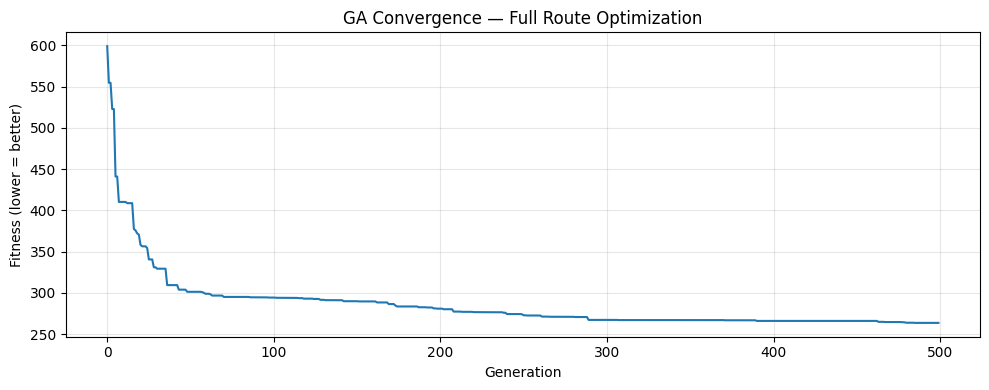

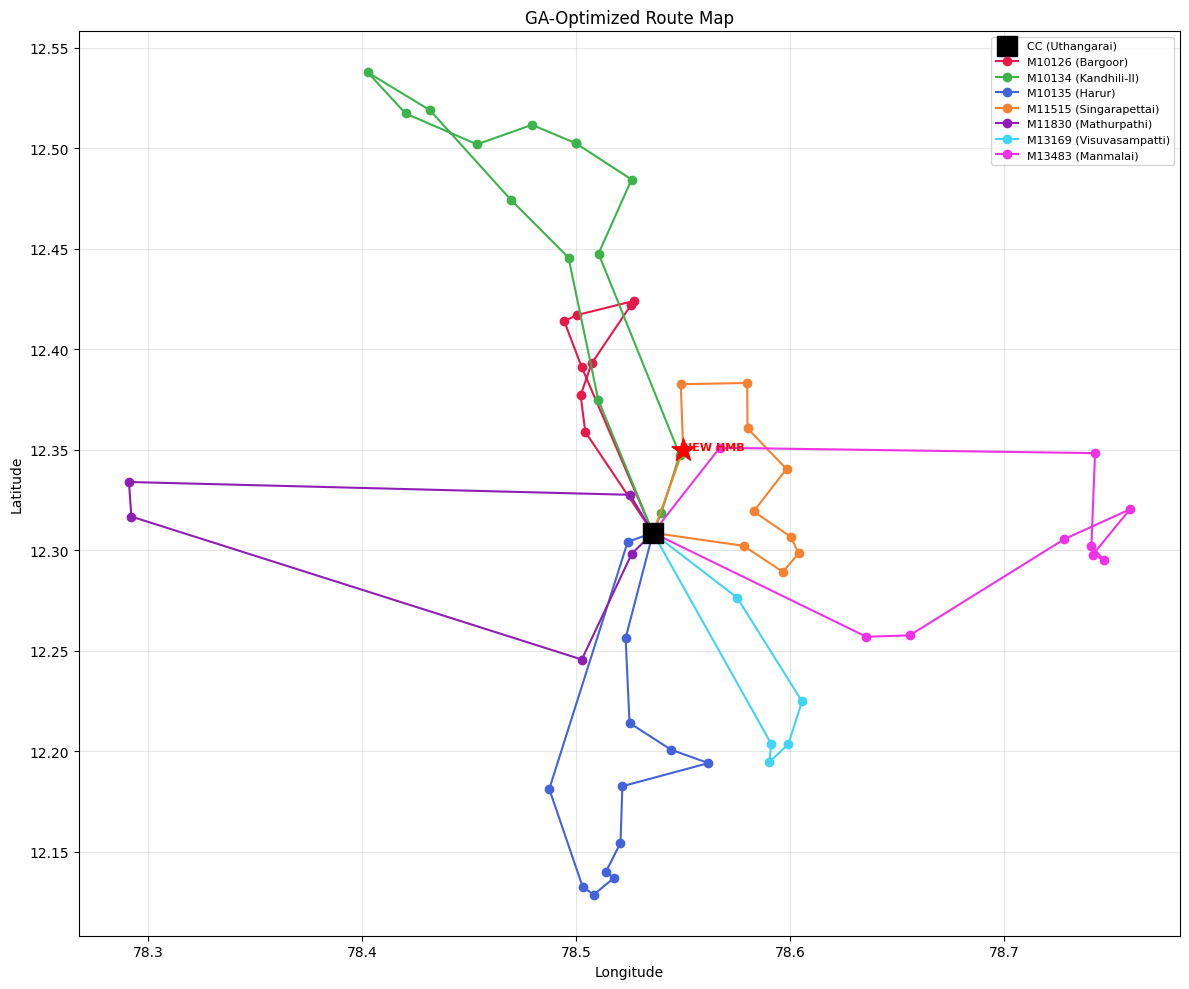

In [27]:
import matplotlib.pyplot as plt

# Plot convergence for full route optimization
if full_results and "history" in full_results:
    plt.figure(figsize=(10, 4))
    plt.plot(full_results["history"], linewidth=1.5)
    plt.title("GA Convergence — Full Route Optimization")
    plt.xlabel("Generation")
    plt.ylabel("Fitness (lower = better)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot route map
routes_data = full_results["routes"]
route_groups = full_results["route_groups"]
colors = ['#e6194b', '#3cb44b', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6']

plt.figure(figsize=(12, 10))
plt.scatter(CC_LON, CC_LAT, c='black', s=200, marker='s', zorder=5, label='CC (Uthangarai)')

for r_idx, group in enumerate(route_groups):
    if not group:
        continue
    route = routes_data[r_idx]
    lats = [CC_LAT] + [item[1][0] for item in group] + [CC_LAT]
    lons = [CC_LON] + [item[1][1] for item in group] + [CC_LON]
    color = colors[r_idx % len(colors)]

    plt.plot(lons, lats, '-o', color=color, linewidth=1.5, markersize=6,
             label=f"{route.code} ({route.name})")

    for _, hmb_data, orig in group:
        marker = '★' if hmb_data[2] == "★ NEW HMB" else ''
        if marker:
            plt.scatter(hmb_data[1], hmb_data[0], c='red', s=300, marker='*', zorder=6)
            plt.annotate("NEW HMB", (hmb_data[1], hmb_data[0]),
                         fontsize=8, fontweight='bold', color='red')

plt.title("GA-Optimized Route Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()